In [1]:
import os
import json
import redis
import pandas as pd 
import matplotlib.pyplot as plt

FILENAME_CSV = "../src/monitoring.csv"

num_packets = {
    "sample.pcap": 88,
    "test_1.pcap": 7707,
    "test_2.pcap": 19731
}

# Loading Data from Redis

In [ ]:
# Load & Format the data from Redis
data_used = "test_1.pcap"
numb_of_packets = 7707

# Redis connection details
redis_host = "localhost"
redis_port = 6379
redis_db = 1
redis_key = "monitoring"

r = redis.StrictRedis(host=redis_host, port=redis_port, db=redis_db, decode_responses=True)

raw_data = r.lrange(redis_key, 0, -1)
print(f"Fetched {len(raw_data)} records from Redis.")

data_list = [json.loads(x) for x in raw_data]
df = pd.DataFrame(data_list)

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['elapsed_time'] = pd.to_numeric(df['elapsed_time'])
df['cpu_usage'] = pd.to_numeric(df['cpu_usage'])
df['ram_usage'] = pd.to_numeric(df['ram_usage'])
df['test_file'] = data_used
df['numb_of_packets'] = numb_of_packets

Fetched 22 records from Redis.


In [ ]:
# Save data to CSV

if os.path.exists(FILENAME_CSV):
    df_existing = pd.read_csv(FILENAME_CSV, parse_dates=['timestamp'])
    df_combined = pd.concat([df_existing, df], ignore_index=True)
    print(f"Existing data loaded. Appending {len(df)} new records.")
else:
    df_combined = df.copy()
    print(f"No existing data found. Creating new dataset with {len(df)} records.")


df_combined.to_csv(FILENAME_CSV, index=False)
print(f"Data saved to {FILENAME_CSV}")


Existing data loaded. Appending 22 new records.
Data saved to ../src/monitoring.csv


In [41]:
# Clean up Redis
r.delete(redis_key)
print(f"Redis key '{redis_key}' has been deleted.")

Redis key 'monitoring' has been deleted.


# Plotting

In [2]:
# Loads data
df = pd.read_csv(FILENAME_CSV)

groups = df.groupby('test_file')

df_list = [group for _, group in groups]
df1, df2, df3 = df_list  # Unpack into variables

In [3]:
# Calculate average parameters
print("TEST 1")

df1_mdl_cpu_mean = df1[df1["code_area"] == "MDL"]["cpu_usage"].mean()
df1_mdl_ram_mean = df1[df1["code_area"] == "MDL"]["ram_usage"].mean()
df1_mdl_elapsed_time_mean = df1[df1["code_area"] == "MDL"]["elapsed_time"].mean()
df1_mdl_throughput = df1_mdl_elapsed_time_mean / num_packets["sample.pcap"]

print(f"Average CPU usage for MDL: {df1_mdl_cpu_mean}%")
print(f"Average RAM usage for MDL: {df1_mdl_ram_mean} MB")
print(f"Average elapsed time for MDL: {df1_mdl_elapsed_time_mean} s")
print(f"Throughput for MDL: {df1_mdl_throughput} pps")
print()

df1_hrs_cpu_mean = df1[df1["code_area"] == "HRS"]["cpu_usage"].mean()
df1_hrs_ram_mean = df1[df1["code_area"] == "HRS"]["ram_usage"].mean()
df1_hrs_elapsed_time_mean = df1[df1["code_area"] == "HRS"]["elapsed_time"].mean()
df1_hrs_throughput = df1_hrs_elapsed_time_mean / num_packets["sample.pcap"]

print(f"Average CPU usage for HRS: {df1_hrs_cpu_mean}%")
print(f"Average RAM usage for HRS: {df1_hrs_ram_mean} MB")
print(f"Average elapsed time for HRS: {df1_hrs_elapsed_time_mean} s")
print(f"Throughput for HRS: {df1_hrs_throughput} pps")
print("----------------------------------------------------")
print("TEST 2")

df2_mdl_cpu_mean = df2[df2["code_area"] == "MDL"]["cpu_usage"].mean()
df2_mdl_ram_mean = df2[df2["code_area"] == "MDL"]["ram_usage"].mean()
df2_mdl_elapsed_time_mean = df2[df2["code_area"] == "MDL"]["elapsed_time"].mean()
df2_mdl_throughput = df2_mdl_elapsed_time_mean / num_packets["test_1.pcap"]

print(f"Average CPU usage for MDL: {df2_mdl_cpu_mean}%")
print(f"Average RAM usage for MDL: {df2_mdl_ram_mean} MB")
print(f"Average elapsed time for MDL: {df2_mdl_elapsed_time_mean} s")
print(f"Throughput for MDL: {df2_mdl_throughput} pps")
print()

df2_hrs_cpu_mean = df2[df2["code_area"] == "HRS"]["cpu_usage"].mean()
df2_hrs_ram_mean = df2[df2["code_area"] == "HRS"]["ram_usage"].mean()
df2_hrs_elapsed_time_mean = df2[df2["code_area"] == "HRS"]["elapsed_time"].mean()
df2_hrs_throughput = df2_hrs_elapsed_time_mean / num_packets["test_1.pcap"]

print(f"Average CPU usage for HRS: {df2_hrs_cpu_mean}%")
print(f"Average RAM usage for HRS: {df2_hrs_ram_mean} MB")
print(f"Average elapsed time for HRS: {df2_hrs_elapsed_time_mean} s")
print(f"Throughput for HRS: {df2_hrs_throughput} pps")
print("----------------------------------------------------")
print("TEST 3")

df3_mdl_cpu_mean = df3[df3["code_area"] == "MDL"]["cpu_usage"].mean()
df3_mdl_ram_mean = df3[df3["code_area"] == "MDL"]["ram_usage"].mean()
df3_mdl_elapsed_time_mean = df3[df3["code_area"] == "MDL"]["elapsed_time"].mean()
df3_mdl_throughput = df3_mdl_elapsed_time_mean / num_packets["test_2.pcap"]

print(f"Average CPU usage for MDL: {df3_mdl_cpu_mean}%")
print(f"Average RAM usage for MDL: {df3_mdl_ram_mean} MB")
print(f"Average elapsed time for MDL: {df3_mdl_elapsed_time_mean} s")
print(f"Throughput for MDL: {df3_mdl_throughput} pps")
print()

df3_hrs_cpu_mean = df3[df3["code_area"] == "HRS"]["cpu_usage"].mean()
df3_hrs_ram_mean = df3[df3["code_area"] == "HRS"]["ram_usage"].mean()
df3_hrs_elapsed_time_mean = df3[df3["code_area"] == "HRS"]["elapsed_time"].mean()
df3_hrs_throughput = df3_hrs_elapsed_time_mean / num_packets["test_2.pcap"]

print(f"Average CPU usage for HRS: {df3_hrs_cpu_mean}%")
print(f"Average RAM usage for HRS: {df3_hrs_ram_mean} MB")
print(f"Average elapsed time for HRS: {df3_hrs_elapsed_time_mean} s")
print(f"Throughput for HRS: {df3_hrs_throughput} pps")


TEST 1
Average CPU usage for MDL: 6.578977272727273%
Average RAM usage for MDL: 665.9016335227273 MB
Average elapsed time for MDL: 0.4647055972706188 s
Throughput for MDL: 0.005280745423529759 pps

Average CPU usage for HRS: 4.307386363636364%
Average RAM usage for HRS: 665.9016335227273 MB
Average elapsed time for HRS: 1.478373809294267 s
Throughput for HRS: 0.016799702378343943 pps
----------------------------------------------------
TEST 2
Average CPU usage for MDL: 10.310795454545454%
Average RAM usage for MDL: 759.3288352272727 MB
Average elapsed time for MDL: 1.09170109575445 s
Throughput for MDL: 0.0001416505898215194 pps

Average CPU usage for HRS: 1.0392045454545453%
Average RAM usage for HRS: 735.0056818181819 MB
Average elapsed time for HRS: 24.10546751455827 s
Throughput for HRS: 0.003127736799605329 pps
----------------------------------------------------
TEST 3
Average CPU usage for MDL: 21.419318181818184%
Average RAM usage for MDL: 2746.1576704545455 MB
Average elapsed 

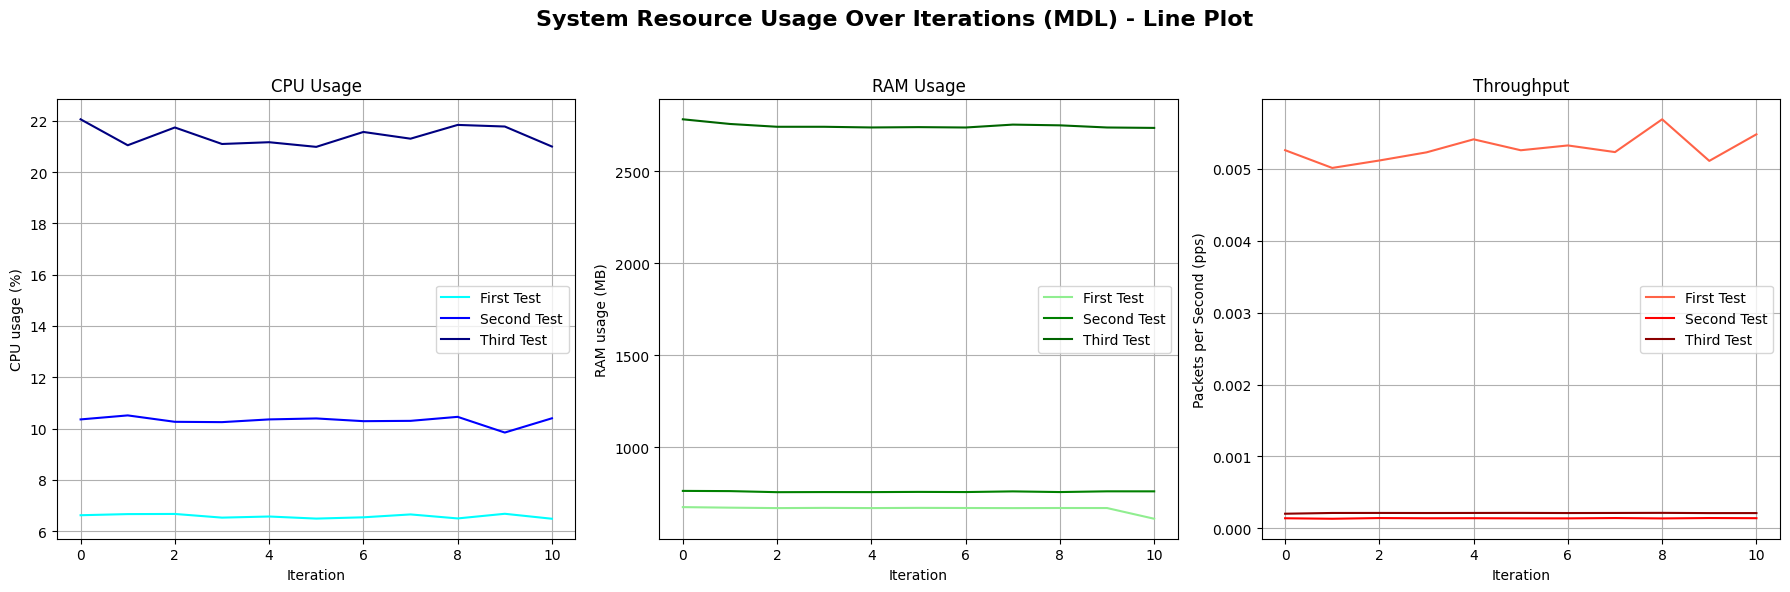

In [15]:
# Line Plot the data
fig = plt.figure(figsize=(18, 6))
fig.suptitle("System Resource Usage Over Iterations (MDL) - Line Plot", fontsize=16, fontweight='bold')

# ---------------------------
# Subplot 1: CPU Usage
# ---------------------------
plt.subplot(1, 3, 1)
# Plot First Test CPU usage
plt.plot(
    range(len(df1[df1["code_area"] == "MDL"])),
    df1[df1["code_area"] == "MDL"]['cpu_usage'],
    label='First Test',
    color='cyan'
)
# Plot Second Test CPU usage
plt.plot(
    range(len(df2[df2["code_area"] == "MDL"])),
    df2[df2["code_area"] == "MDL"]['cpu_usage'],
    label='Second Test',
    color='blue'
)
# Plot Third Test CPU usage
plt.plot(
    range(len(df3[df3["code_area"] == "MDL"])),
    df3[df3["code_area"] == "MDL"]['cpu_usage'],
    label='Third Test',
    color='navy'
)
plt.xlabel('Iteration')
plt.ylabel('CPU usage (%)')
plt.title('CPU Usage')
plt.legend()
plt.grid(True)

# ---------------------------
# Subplot 2: RAM Usage
# ---------------------------
plt.subplot(1, 3, 2)
# Plot First Test RAM usage
plt.plot(
    range(len(df1[df1["code_area"] == "MDL"])),
    df1[df1["code_area"] == "MDL"]['ram_usage'],
    label='First Test',
    color='lightgreen'
)
# Plot Second Test RAM usage
plt.plot(
    range(len(df2[df2["code_area"] == "MDL"])),
    df2[df2["code_area"] == "MDL"]['ram_usage'],
    label='Second Test',
    color='green'
)
# Plot Third Test RAM usage
plt.plot(
    range(len(df3[df3["code_area"] == "MDL"])),
    df3[df3["code_area"] == "MDL"]['ram_usage'],
    label='Third Test',
    color='darkgreen'
)
plt.xlabel('Iteration')
plt.ylabel('RAM usage (MB)')
plt.title('RAM Usage')
plt.legend()
plt.grid(True)

# ---------------------------
# Subplot 3: Throughput (Packets per Second)
# ---------------------------
plt.subplot(1, 3, 3)
# Plot First Test Throughput
plt.plot(
    range(len(df1[df1["code_area"] == "MDL"])),
    df1[df1["code_area"] == "MDL"]['elapsed_time'].div(num_packets["sample.pcap"]),
    label='First Test',
    color='tomato'
)
# Plot Second Test Throughput
plt.plot(
    range(len(df2[df2["code_area"] == "MDL"])),
    df2[df2["code_area"] == "MDL"]['elapsed_time'].div(num_packets["test_1.pcap"]),
    label='Second Test',
    color='red'
)
# Plot Third Test Throughput
plt.plot(
    range(len(df3[df3["code_area"] == "MDL"])),
    df3[df3["code_area"] == "MDL"]['elapsed_time'].div(num_packets["test_2.pcap"]),
    label='Third Test',
    color='darkred'
)
plt.xlabel('Iteration')
plt.ylabel('Packets per Second (pps)')
plt.title('Throughput')
plt.legend()
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


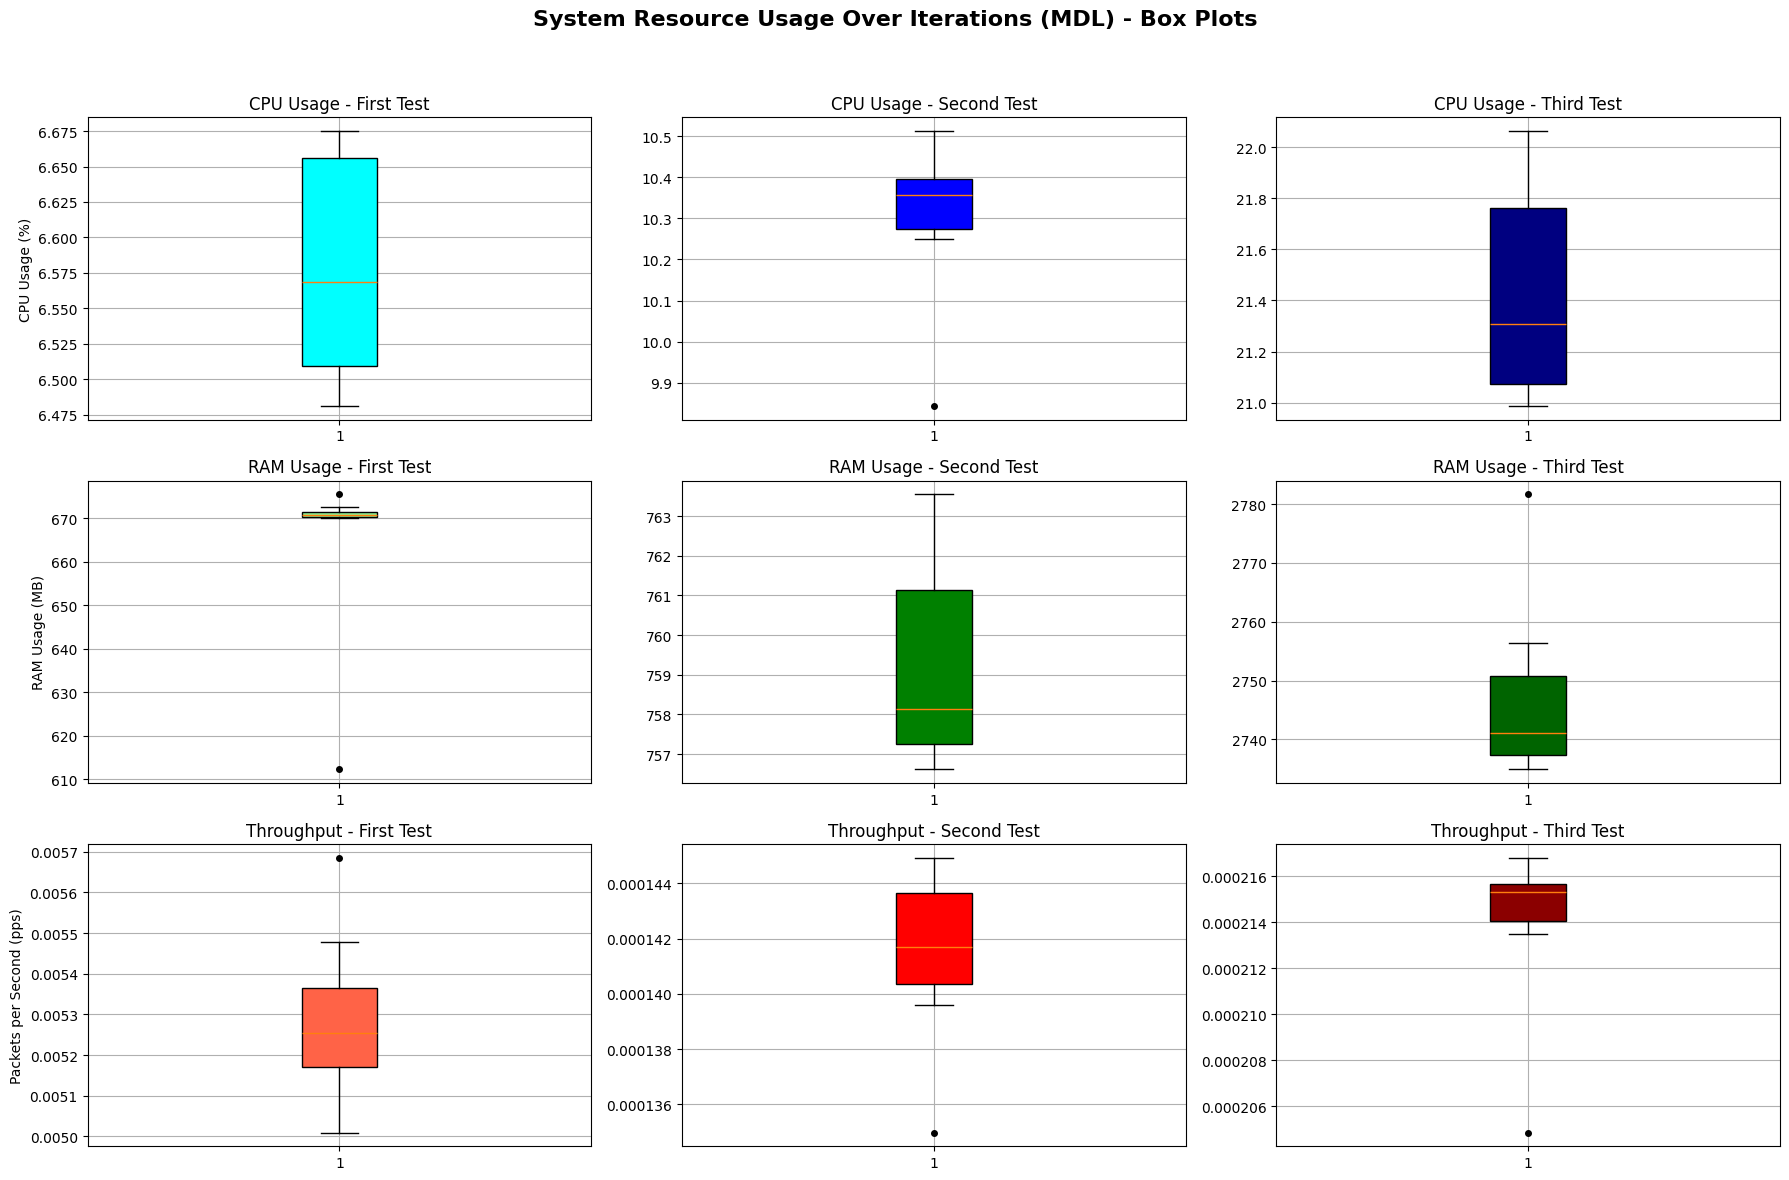

In [ ]:
# ---------------------------
# Prepare data for each metric, per test
# ---------------------------
df1_cpu = df1[df1["code_area"] == "MDL"]['cpu_usage']
df2_cpu = df2[df2["code_area"] == "MDL"]['cpu_usage']
df3_cpu = df3[df3["code_area"] == "MDL"]['cpu_usage']

df1_ram = df1[df1["code_area"] == "MDL"]['ram_usage']
df2_ram = df2[df2["code_area"] == "MDL"]['ram_usage']
df3_ram = df3[df3["code_area"] == "MDL"]['ram_usage']

df1_throughput = df1[df1["code_area"] == "MDL"]['elapsed_time'].div(num_packets["sample.pcap"])
df2_throughput = df2[df2["code_area"] == "MDL"]['elapsed_time'].div(num_packets["test_1.pcap"])
df3_throughput = df3[df3["code_area"] == "MDL"]['elapsed_time'].div(num_packets["test_2.pcap"])

# ---------------------------
# Create a 3x3 figure
# Rows:    CPU (row 0), RAM (row 1), Throughput (row 2)
# Columns: First Test (col 0), Second Test (col 1), Third Test (col 2)
# ---------------------------
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
fig.suptitle("System Resource Usage Over Iterations (MDL) - Box Plots", 
             fontsize=16, fontweight='bold')

# ---------------------------
# Row 1: CPU Usage (%)
# ---------------------------
bp_cpu_1 = axes[0, 0].boxplot(
    df1_cpu, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[0, 0].set_title("CPU Usage (%) - First Test")
axes[0, 0].set_ylabel("CPU Usage (%)")
axes[0, 0].grid(True)

bp_cpu_2 = axes[0, 1].boxplot(
    df2_cpu, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[0, 1].set_title("CPU Usage (%) - Second Test")
axes[0, 1].grid(True)

bp_cpu_3 = axes[0, 2].boxplot(
    df3_cpu, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[0, 2].set_title("CPU Usage (%) - Third Test")
axes[0, 2].grid(True)

# Color each CPU box a different shade of blue
bp_colors_cpu = ['cyan', 'blue', 'navy']
for bp, color in zip([bp_cpu_1, bp_cpu_2, bp_cpu_3], bp_colors_cpu):
    for patch in bp['boxes']:
        patch.set_facecolor(color)

# ---------------------------
# Row 2: RAM Usage (MB)
# ---------------------------
bp_ram_1 = axes[1, 0].boxplot(
    df1_ram, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[1, 0].set_title("RAM Usage (MB) - First Test")
axes[1, 0].set_ylabel("RAM Usage (MB)")
axes[1, 0].grid(True)

bp_ram_2 = axes[1, 1].boxplot(
    df2_ram, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[1, 1].set_title("RAM Usage (MB) - Second Test")
axes[1, 1].grid(True)

bp_ram_3 = axes[1, 2].boxplot(
    df3_ram, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[1, 2].set_title("RAM Usage (MB) - Third Test")
axes[1, 2].grid(True)

# Color each RAM box a different shade of green
bp_colors_ram = ['lightgreen', 'green', 'darkgreen']
for bp, color in zip([bp_ram_1, bp_ram_2, bp_ram_3], bp_colors_ram):
    for patch in bp['boxes']:
        patch.set_facecolor(color)

# (Optional) Use a log scale if RAM usage differs widely:
# axes[1, 0].set_yscale('log')
# axes[1, 1].set_yscale('log')
# axes[1, 2].set_yscale('log')

# ---------------------------
# Row 3: Throughput (pps)
# ---------------------------
bp_th_1 = axes[2, 0].boxplot(
    df1_throughput, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[2, 0].set_title("Throughput (pps) - First Test")
axes[2, 0].set_ylabel("Packets per Second (pps)")
axes[2, 0].grid(True)

bp_th_2 = axes[2, 1].boxplot(
    df2_throughput, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[2, 1].set_title("Throughput (pps) - Second Test")
axes[2, 1].grid(True)

bp_th_3 = axes[2, 2].boxplot(
    df3_throughput, 
    patch_artist=True,
    flierprops=dict(marker='o', markerfacecolor='black', markersize=4)
)
axes[2, 2].set_title("Throughput (pps) - Third Test")
axes[2, 2].grid(True)

# Color each Throughput box a different shade of red
bp_colors_th = ['tomato', 'red', 'darkred']
for bp, color in zip([bp_th_1, bp_th_2, bp_th_3], bp_colors_th):
    for patch in bp['boxes']:
        patch.set_facecolor(color)

# ---------------------------
# Final layout adjustments
# ---------------------------
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
